In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from collections import namedtuple

import checker
import utils

plt.rcParams["figure.figsize"] = (9, 5)

# Część pierwsza: PCA

## Zadanie 1 (2 pkt.)
## Principal Component Analysis
Zaimplementuj algorytm PCA tak jak został on opisany na wykładzie. Możesz korzystać z funkcji wyliczających wektory i wartości własne macierzy, ale nie można używać gotowych metod implementujących PCA.

W metodzie `fit` należy:
* Zapamiętać średnią datasetu $\textrm{mean}X$.
* Policzyć macierz kowariancji podanego zbioru X.
* Policzyć wektory własne $V$ i wartości własne $\lambda_i$ macierzy kowariancji. (Podpowiedź: jest do tego odpowiednia funkcja w numpy, nie trzeba tego robić ręcznie). 
* Wybrać wektory własne odpowiadające $k$ największym wartościom własnym, zapisać je jako macierz $W$.
   
W metodzie `transform` należy:
* Przesunąć dataset podany na wejściu odemując średni wektor zapamiętany przy fitowaniu.
    $$
    Y = X - \textrm{mean}X
    $$
* Rzutować ten dataset na podprzestrzeń rozpinaną przez wybrane wektory własne. Czyli:
    $$ 
    Z = W^TY,
    $$
    gdzie $W$ to macierz składająca się z wybranych wektorów własnych. Przyjmujemy tu zapis wektorów pionowych, w kodzie chcemy wektory poziome.
    
$k$, czyli wymiar przestrzeni, którą uzyskamy po rzutowaniu, należy wybrać w następujący sposób:
* Jeżeli `n_components` zostało podane, należy skorzystać z tej liczby.
* Jeżeli zamiast `n_components` zostało podane `var_to_explain` (w zakresie `[0, 1]`), należy wybrać najmniejsze `k`, takie że wariancja tłumaczona przez zrzutowane dane wynosi co najmniej `var_to_explain` wariancji oryginalnego datasetu.

In [6]:
class PCA:
    def __init__(self, n_components=None, var_to_explain=None):
        assert n_components is not None or var_to_explain is not None
        assert n_components is None or var_to_explain is None
        self.n_components = n_components
        self.var_to_explain = var_to_explain
        self.W=None
        self.mean=None
        
    def fit(self, X):
        self.mean=np.mean(X,axis=0)
        C=np.cov(X.T)
        #print(C.shape)
        eigenvalues,eigenvectors=np.linalg.eigh(C)
        #print(e)
        take=None #tu beda indexy wektorw ktore mam zabrac
        if self.n_components!=None :
            take=np.flip(np.argsort(eigenvalues))[0:self.n_components]
            #print("tu bylem")
        else:
            values=eigenvalues[np.flip(np.argsort(eigenvalues))] # psortowane wlasne
            #print(values)
            values=values/np.sum(values) #sklad procentowy
            #print("valuesshape",values.shape)
            suma,ind=0,0
            while(suma<self.var_to_explain):
                suma=suma+values[ind]
                ind=ind+1
            take=np.flip(np.argsort(eigenvalues))[:ind]
        self.W=eigenvectors.T[take]
        #print(eigenvector)
        #print("eigen" ,self.W.shape)
        #print("xshape",X.shape)
        
              
    def transform(self, X):
        Y=X-self.mean
        Z=(self.W.dot(Y.T)).T
        #print("Zshape",Z.shape)
        #print(self.n_components,self.var_to_explain)
        return Z

In [7]:
checker.check_02_pca(PCA)

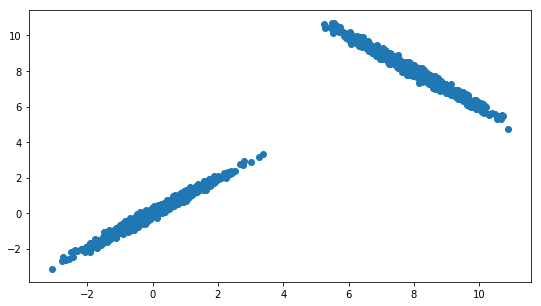

Dataset Toy dataset, Data dimension after the projection: 1


AttributeError: 'PathCollection' object has no attribute 'legend_elements'

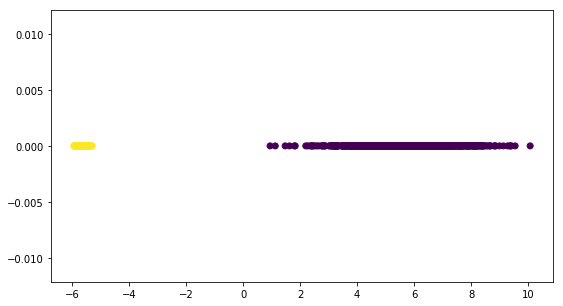

In [8]:
toy_dataset = utils.get_toy_dataset()
plt.scatter(toy_dataset.data[:, 0], toy_dataset.data[:, 1])
plt.show() 

utils.test_pca("Toy dataset", PCA, toy_dataset, var_to_explain=0.90)

Dataset Iris, Data dimension after the projection: 1


AttributeError: 'PathCollection' object has no attribute 'legend_elements'

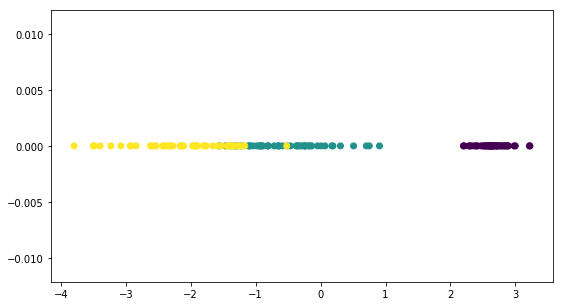

In [9]:
utils.test_pca("Iris", PCA, datasets.load_iris(), var_to_explain=0.90)
utils.test_pca("Iris", PCA, datasets.load_iris(), var_to_explain=0.94)
utils.test_pca("Digits", PCA, datasets.load_digits(), n_components=10)
utils.test_pca("Wine", PCA, datasets.load_wine(), n_components=2)

# Część druga: regresja liniowa

Wprowadźmy sobie teraz pewien podział metod uczenia maszynowego:
1. Jak dotąd nasz zbiór treningowy składał się po prostu z listy przykładów: $X = (x_1, \ldots, x_n)$, gdzie $x_i \in \mathbb{R}^D$. Tę sytuację możemy nazwać **uczeniem nienadzorowanym** (unsupervised learning) i zazwyczaj chcemy wtedy znaleźć ciekawe właściwości naszego zbioru danych.

    Dla przykładu omawiany tydzień temu algorytm klastrowania to przykład uczenia nienadzorowany - ciekawą właściwością naszego zbioru danych był wówczas podział na grupy (klastry).
    

2. Teraz nasz zbiór będzie składał się z par: przykład $x_i$ oraz jego etykieta $y_i$, tzn.: $X = ((x_1, y_1), \ldots (x_n, y_n))$, gdzie $x_i \in \mathbb{R}^D$ natomiast $y_i \in \mathbb{R}^K$. Tę sytuację nazywamy **uczeniem nadzorowanym** i chcemy tutaj zazwyczaj znaleźć jakąś funkcję $f(x) = y$, która dla niewidzianego jeszcze przykładu $\bar{x}$ jest w stanie nam zwrócić sensowną etykietę $y$. 
    
    Dla przykładu możemy wyobrazić sobie, że każdy przykład $x$ z naszego datasetu opisuje atrybuty pewnego domu - liczbę pokoi, metraż, rok budowy, odległość w metrach od centrum miasta itd. - a etykiety $y$ reprezentują ceny tego domu. My chcielibyśmy zbudować model, który na podstawie atrybutów $x$ nowego domu, będzie w stanie dać rozsądną predykcję na temat jego ceny.


Dla uproszczenia dzisiaj przyjmiemy, że $K=1$, tzn. że nasze etykiety $y$ są jednowymiarowe. Natomiast wszystkie omawiane metody można łatwo przenieść do sytuacji wyżej wymiarowych.

### Przygotujmy sobie na początek parę datasetów i je zwizualizujmy:
Przyjmujemy, że nasz dataset jest rozmiarów `[N, D]` (na ten moment `D = 1`) natomiast etykiety to wektory o długości `N`. Stwórzmy sobie kilka "zabawkowych" datasetów.

In [10]:
from collections import namedtuple
np.random.seed(54)

def linear_func(X):
    return -2.5 * X

def affine_func(X):
    return  -2.5 * X + 2

def square_func(X):
    return -2 * X ** 2 + 1 * X + 1

linear_dataset = utils.create_regression_dataset(linear_func)
affine_dataset = utils.create_regression_dataset(affine_func)
square_dataset = utils.create_regression_dataset(square_func)
bigger_square_dataset = utils.create_regression_dataset(square_func, sample_size=100)

Każdy z naszych datasetów zawiera atrybut .data z danymi X oraz .target z etykietami Y
linear_dataset.data: [[-0.39908516]
 [-0.68380252]
 [-1.57561656]
 [ 0.09141364]
 [-2.45697274]
 [ 2.34468103]
 [ 1.50690628]
 [ 1.28655994]
 [ 0.85742151]
 [-2.35171496]]
linear_dataset.target: [ 0.7035172   1.37442238  4.05564692 -0.36402631  6.27794289 -5.82459669
 -3.9986326  -3.38031002 -2.32424686  5.77345025]
Wszystkie datasety mają jednowymiarowe przykłady: (10, 1)


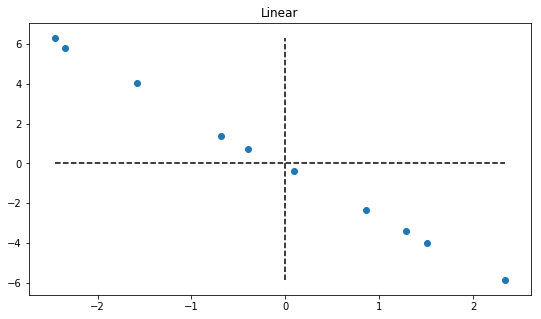

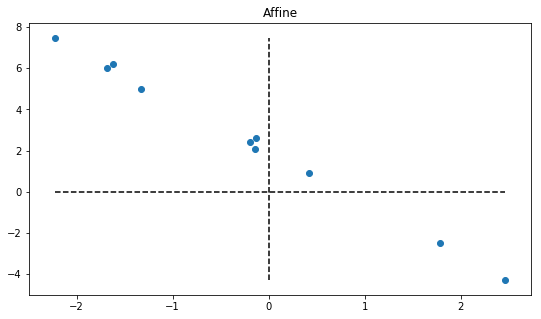

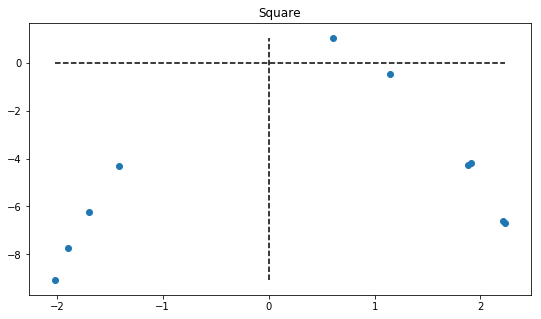

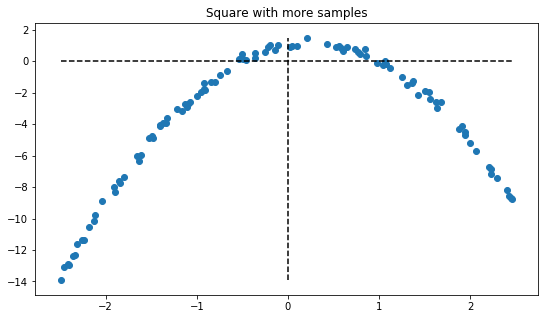

In [11]:
print("Każdy z naszych datasetów zawiera atrybut .data z danymi X oraz .target z etykietami Y")
print(f"linear_dataset.data: {linear_dataset.data}\nlinear_dataset.target: {linear_dataset.target}")
print(f"Wszystkie datasety mają jednowymiarowe przykłady: {linear_dataset.data.shape}")

utils.plot_regression_dataset(linear_dataset, "Linear")
utils.plot_regression_dataset(affine_dataset, "Affine")
utils.plot_regression_dataset(square_dataset, "Square")
utils.plot_regression_dataset(bigger_square_dataset, "Square with more samples")

## Zadanie 2 (2 pkt.)
## Regresja liniowa

Przyjmijmy, że nasza funkcja, która na podstawie $x \in \mathbb{R}^{D}$ ma nam dać jego etykietę $y$ wygląda tak:
$$ f(x) = w^T x, $$
gdzie $w$ to wektor o długości $D$.

$w$ to parametry naszego modelu - w kontekście regresji liniowej (a potem sieci neuronowych) nazywa się je też wagami.

Próbujemy znaleźć takie parametry $w$, które zminimalizują następującą funkcję mean squared error liczoną pomiędzy predykcjami naszego modelu a prawdziwymi etykietami z datasetu:
$$
L(X, y, w) = \frac{1}{N} \sum_{i=1}^N ( f(x) - y_i )^2 = \frac{1}{N} \sum_{i=1}^N (w^Tx - y_i)^2
$$

Okazuje się, że jest na to jawny wzór (szczegóły w wykładzie):
$$ w = (X X^T)^{-1} X y $$


W zadaniu należy zaimplementować ponownie metodę sklearn:

1. W metodzie `fit` należy obliczyć wektor wag rozwiązujących problem regresji dla podanej macierzy `X` o wymiarach `[N, D]` oraz dla podanego wektora etykiet `y`. Należy skorzystać z powyższego jawnego wzoru.
2. Metoda `predict` ma zwracać dla podanej macierzy numpy `X` o wymiarach `[N, D]` wektor predykcji o wymiarze `[N]`.
3. W metodzie `loss` należy zaimplementować liczenie kosztu $L(X, y, w)$. Należy zwrócić skalar.


**UWAGA: self.weight ma być wektorem jednowymiarowym. Nie może być macierzą ani skalarem.**

In [12]:
class LinearRegression:
    def __init__(self):
        self.weight = None
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        y=np.reshape(y,(-1,1))
        self.weight=np.linalg.inv(np.matmul(X.T,X)).dot(X.T.dot(y))
        #self.weight=np.reshape(self.weight)
        #print(self.weight.shape)
    def predict(self, X: np.ndarray) -> np.ndarray:
        return np.reshape((self.weight.T.dot(X.T)).T,-1)

    def loss(self, X: np.ndarray, y: np.ndarray) -> float:
        return np.mean((self.weight.T.dot(X.T)-y)**2)

In [13]:
checker.check_02_linear_regression(LinearRegression)

Dataset Linear
Wartość funkcji kosztu: 0.036210463807280734


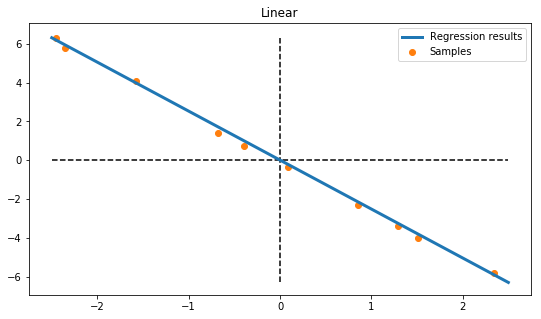

Dataset Affine
Wartość funkcji kosztu: 3.6278665190688377


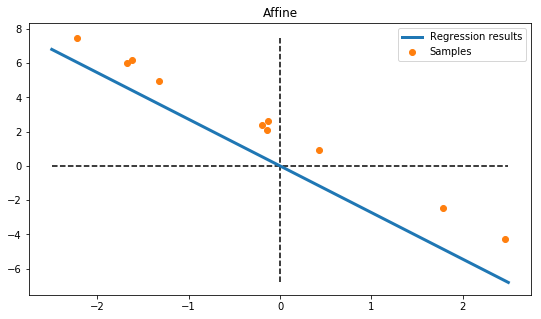

Dataset Square
Wartość funkcji kosztu: 32.393508382556384


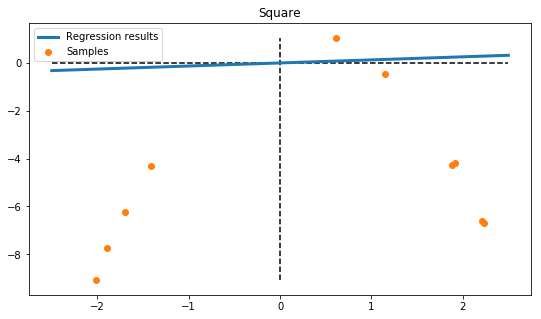

In [14]:
utils.plot_regression_results(linear_dataset, LinearRegression, "Linear")
utils.plot_regression_results(affine_dataset, LinearRegression, "Affine")
utils.plot_regression_results(square_dataset, LinearRegression, "Square")

## Zanurzenia i funkcje bazowe

W aktualnej wersji regresja liniowa potrafi modelować tylko funkcje liniowe, które przechodzą przez środek osi układu współrzędnych. Chcielibyśmy, żeby regresja potrafiła modelować również inne funkcje. Konkretniej:

1. Funkcje afiniczne, tzn. $f(x) = w_1x + w_0$
2. Współczynniki w funkcjach wielomianowych, tzn. $f(x) = w_0 + w_1 x + w_2 x^2 + \ldots + w_n x^n$
3. Funkcje zbudowane z funkcji trygonometrycznych, tzn. $f(x) = w_0 + w_1 x + w_2 \sin(x) + w_3 \cos(x)$

Żeby to osiągnąć możemy przetransformować (zanurzyć) nasze danel:
1. $ \tilde{x_i} = [1, x_i] $
2. $ \tilde{x_i} = [1, x_i, x_i ^ 2, ... x_i ^ n] $
3. $ \tilde{x_i} = [1, x_i, \sin(x), \cos(x)] $

Po zanurzeniu możemy wykonać naszą regresję liniową na zbiorze $\tilde{X} = ((\tilde{x}_1, y_1), \ldots, (\tilde{x}_n, y_n))$. Oznacza to, że przygotowujemy ręcznie naszemu modelowi reprezentację naszego datasetu, którą da się rozwiązać liniowo. Sieci neuronowe, którymi zajmiemy się już niedługo, będą potrafiły taką reprezentację otrzymać samodzielnie.

In [15]:
def embed_bias(X: np.ndarray):
    return np.concatenate([X, np.ones_like(X)], -1)
    
def embed_poly(X: np.ndarray, poly_degree=2):
    polys = [X ** degree for degree in range(poly_degree + 1)]
    return np.concatenate(polys, axis=-1)

def embed_trig(X: np.ndarray):
    trig_list = [np.ones_like(X), X, np.sin(X), np.cos(X)]
    return np.concatenate(trig_list, -1)

Dataset Affine (bias embedding)
Wartość funkcji kosztu: 0.028126132148994076


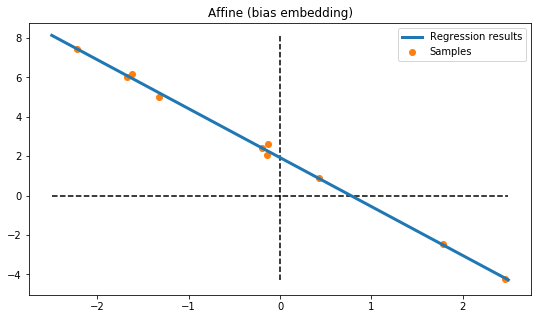

Dataset Square (bias embedding)
Wartość funkcji kosztu: 7.8235459295487955


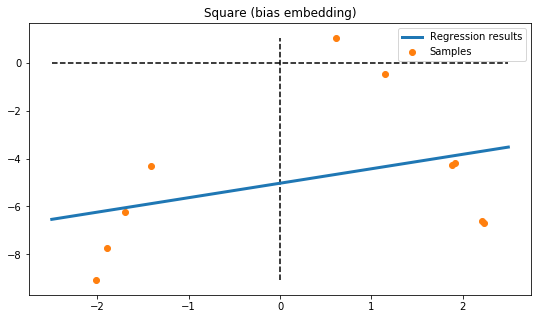

Dataset Square (trig embedding)
Wartość funkcji kosztu: 0.12480462554195597


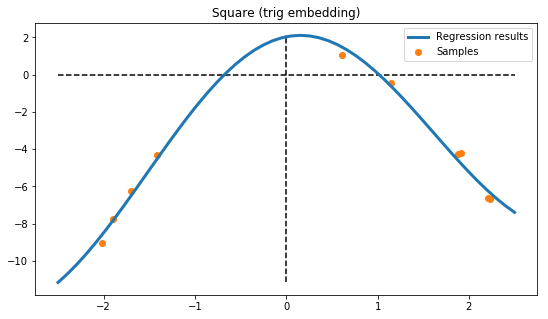

In [16]:
utils.plot_regression_results(
    affine_dataset, LinearRegression,
    "Affine (bias embedding)", embed_bias
)
utils.plot_regression_results(
    square_dataset, LinearRegression,
    "Square (bias embedding)", embed_bias
)
utils.plot_regression_results(
    square_dataset, LinearRegression,
    "Square (trig embedding)", embed_trig
)

## Underfitting i overfitting

Dataset Square (poly embedding, degree=1)
Wartość funkcji kosztu: 7.8235459295487955


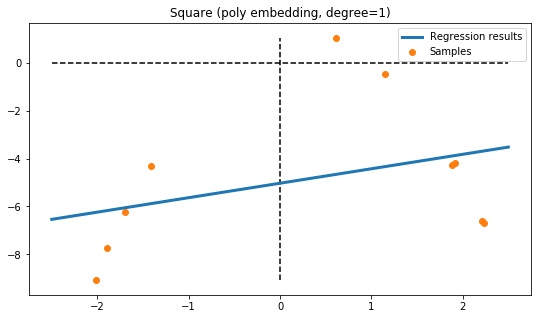

Dataset Square (poly embedding, degree=2)
Wartość funkcji kosztu: 0.009882139636270913


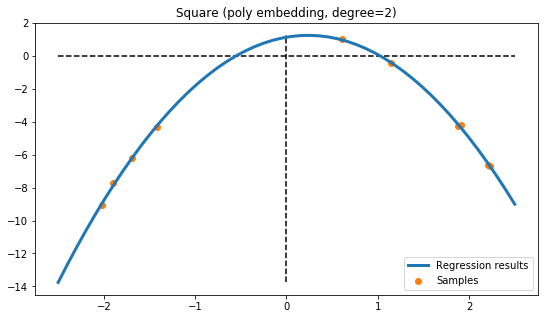

Dataset Square (poly embedding, degree=9)
Wartość funkcji kosztu: 5.5743036546065347e-14


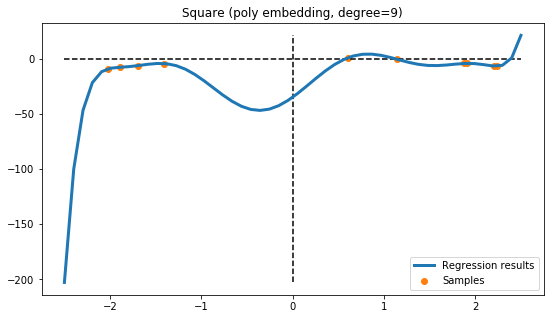

In [17]:
utils.plot_regression_results(
    square_dataset, LinearRegression,
    "Square (poly embedding, degree=1)",
    embed_poly, poly_degree=1
)
utils.plot_regression_results(
    square_dataset, LinearRegression,
    "Square (poly embedding, degree=2)",
    embed_poly, poly_degree=2
)
utils.plot_regression_results(
    square_dataset, LinearRegression,
    "Square (poly embedding, degree=9)",
    embed_poly, poly_degree=9
)

## Jak sobie radzić z overfittingiem?

### Sposób 1: Więcej danych

Dataset Square (poly embedding)
Wartość funkcji kosztu: 0.03656955120600253


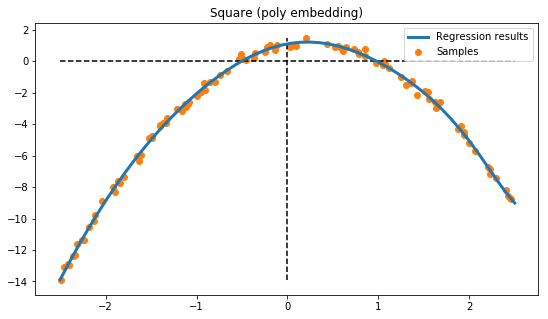

In [18]:
utils.plot_regression_results(
    bigger_square_dataset, LinearRegression,
    "Square (poly embedding)",
    embed_poly, poly_degree=9
)

### Sposób 2: Regularyzacja
Możemy też spróbować zmniejszych pojemność naszego modelu. To będziemy wykonywać w kolejnym zadaniu.

## Zadanie 3 (3 pkt.)
## Regularyzowana regresja liniowa
Czasami nie mamy wpływu na zanurzenie datasetu albo znalezienie prawidłowego zanurzenia jest bardzo trudne. Jeżeli widzimy, że nasz model overfituje do danych, możemy spróbować **regularyzacji modelu**. Zamiast zmieniać nasze dane, zmieniamy nasz model, ograniczając jego ekspresywność. W tym zadaniu należy zaimplementować regresję liniową z kosztem L2 regularyzacji wag. To oznacza, że nasza ostateczna funkcja kosztu będzie wyglądała następująco:

$$
L(X, y, w) = \frac{1}{N} \sum_{i=1}^N (w_i^T x_i - y_i )^2 + \alpha \|w\|^2,
$$
gdzie $\alpha$ to hiperparametr podawany przy tworzeniu funkcji.

Należy zaimplementować klasę, która będzie minimalizować powyższą funkcję za pomocą metody spadku gradientu. W szczególności trzeba zaimplementować metody:
* `fit` - dostaje na wejściu macierz przykładów `X`, wektor etykiet `y` oraz `n_steps`, czyli liczbę naturalną oznaczającą liczbę kroków w metodzie spadku gradientu. W funkcji należy zaimplementować metodę spadku gradientu, tak żeby otrzymać odpowiednie wagi.
* `predict` - dla podanej macierzy `X` podaje wektor predykcji `y`, obliczany za pomocą uzyskanych wag.
* `loss` - zwraca wartość funkcji kosztu policzonej dla podanej macierzy `X` oraz wektora etykiet `y`.



In [20]:
class RegularizedLinearRegression:
    def __init__(self, lr=1e-6, alpha=1e-2):
        self.learning_rate = lr
        self.alpha = alpha

    def fit(self, X: np.ndarray, y: np.ndarray, n_steps=int(5e4)) -> None:
        self.weight = np.random.normal(size=X.shape[1])  # Initializing the weights
        for i in range(n_steps):
            #gradiend mean(wx-y)
            wki=2*(self.weight.dot(X.T)-y) #tablica z wx-y dla kazdego i
            new_wki=np.reshape(wki,(-1,1))
            ten=new_wki*X  #w wierszach gradienty dla kazdego i
            grad1=np.mean(ten,axis=0)
            grad2=self.alpha*2*self.weight #gradient po w
            grad=(grad1+grad2)
            self.weight=self.weight-grad*self.learning_rate

    def predict(self, X: np.ndarray):
        return self.weight.dot(X.T)

    def loss(self, X: np.ndarray, y: np.ndarray):
        return np.mean((self.weight.dot(X.T)-y)**2)+self.alpha*np.linalg.norm(self.weight)**2

In [21]:
checker.check_02_regularized_linear_regression(RegularizedLinearRegression)

Dataset Squared (poly embedding of 9, alpha=0)
Wartość funkcji kosztu: 5.5743036546065347e-14


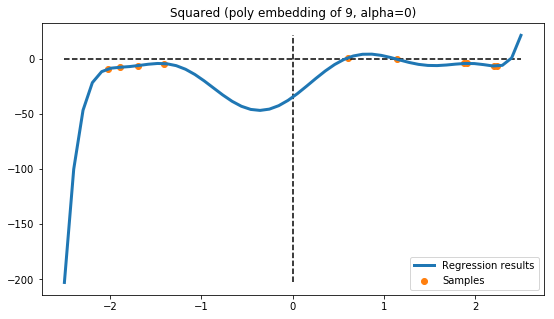

Dataset Squared (poly embedding of 9, alpha=0)
Wartość funkcji kosztu: 0.3778714411333381


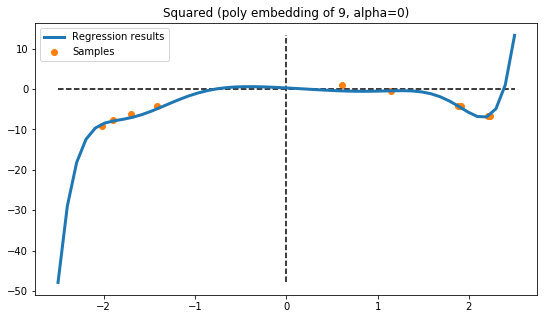

Dataset Squared (poly embedding of 9, alpha=0.01)
Wartość funkcji kosztu: 1.0474516815887889


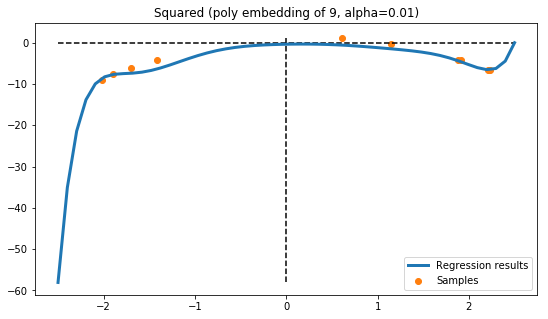

Dataset Squared (poly embedding of 9, alpha=1.0)
Wartość funkcji kosztu: 2.7226450577534695


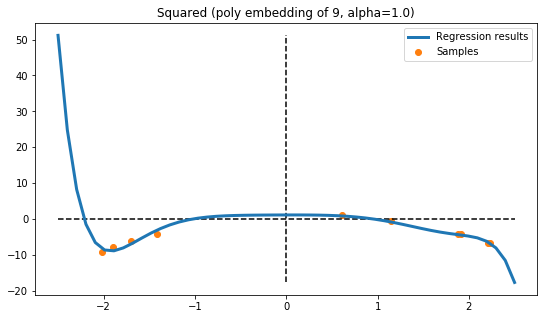

Dataset Squared (poly embedding of 9, alpha=100.0)
Wartość funkcji kosztu: 3.232191406155547


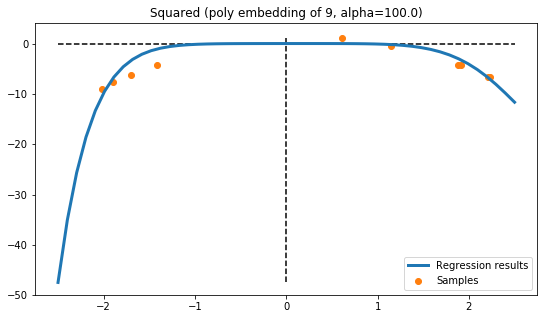

Dataset Squared (poly embedding of 9, alpha=200000)
Wartość funkcji kosztu: 25.291050905711742


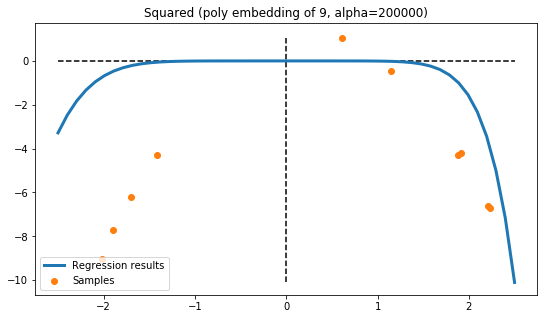

In [22]:
utils.plot_regression_results(
    square_dataset, LinearRegression,
    name=f"Squared (poly embedding of 9, alpha=0)",
    embed_func=embed_poly, poly_degree=9
)

for alpha in [0, 1e-2,  1., 100., int(2e5)]:
    utils.plot_regression_results(
        square_dataset, RegularizedLinearRegression,
        regression_kwargs={"lr": 1e-6, "alpha": alpha},
        name=f"Squared (poly embedding of 9, alpha={alpha})",
        embed_func=embed_poly, poly_degree=9
    )

### Dygresje
* PCA nie jest jedyną metodą do wizualizacji danych wysokowymiarowych. Szczególnie popularne w machine learningu jest jeszcze [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).
* MSE jako funkcja kosztu w regresji liniowej można wyprowadzić z perspektywy rachunku prawdopodobieństwa. Jeśli przyjmiejmy, że do naszych etykiet został dodany szum z rozkładu Gaussowskiego o średniej 0, a następnie będziemy skorzystamy z Maximum Likelihood Estimation, to dojdziemy do dobrego wyniku. [Więcej tutaj](https://stats.stackexchange.com/a/265430).
* Regularyzacja będzie pojawiać się później bardzo często w kontekście sieci neuronowych -- nakładanie kar na normę wag to tylko najprostsza z możliwych metod.